In [1]:
import numpy
import math

import random
import time
import matplotlib.pyplot as plt
import collections
from scipy.optimize import curve_fit

In [2]:
environment = numpy.zeros((2, 7))
trans_prob = 0.7
environment[1, 6] = 10
#environment[8, 8] = -10
environment[1, 0] = 5

In [3]:
alpha = 0.5
gamma = 0.9

In [4]:
def softmax(values):
    scoreMatExp = numpy.exp(numpy.asarray(values))
    return scoreMatExp / scoreMatExp.sum(0)

In [5]:
def action_from_softmax(softmax_scores):
    random_number = numpy.random.random_sample()
    cumm_sum = numpy.cumsum(softmax_scores)
    for i in range(len(softmax_scores)):
        if random_number < cumm_sum[i]:
            return i

In [6]:
def get_legal_actions(pos):
    legal_actions = list()
    new_pos = list()
    all_actions = [[1, 0], [0, 1], [-1, 0], [0, -1]]
    for i in all_actions:
        try:
            new_pos = numpy.add(pos, numpy.array(i))
            legal_actions.append(i)
            env = environment[new_pos[0]][new_pos[1]]
            if any(j < 0 for j in new_pos):
                legal_actions.pop()
        except IndexError:
            legal_actions.pop()
            
        
    return legal_actions

In [7]:
def take_action(pos, action):
    # Take action in the actual environment and return a reward and new position based on environment dynamics
    if numpy.random.rand(1) < trans_prob:
        new_pos = numpy.add(pos, action)
    else:
        new_pos = numpy.add(pos, random.choice(get_legal_actions(pos)))
    reward = environment[new_pos[0]][new_pos[1]]
    return new_pos, reward

In [8]:
def mb_internal_environment_value(pos, mb_internal_environment):
    value = mb_internal_environment[pos[0], pos[1]]
    return value

In [9]:
def update_mb_internal_environment(pos, next_pos, reward, mb_internal_environment):
    next_value_list = list()
    for i in get_legal_actions(next_pos):
        next_value_list.append(mb_internal_environment[next_pos[0]][next_pos[1]])
    next_value = max(next_value_list)
    error = reward + gamma*next_value - mb_internal_environment_value(pos, mb_internal_environment)
    mb_internal_environment[pos[0], pos[1]] = mb_internal_environment_value(pos, mb_internal_environment) + alpha * error
    return mb_internal_environment


In [10]:
def dls(pos, curr_depth, max_depth, mb_internal_environment):
    value_list = list()
    if curr_depth == max_depth:
        return mb_internal_environment_value(pos, mb_internal_environment)
    else:
        actions = get_legal_actions(pos)
        for i in actions:
            next_pos = numpy.add(numpy.array(pos), numpy.array(i))
            value = mb_internal_environment_value(pos, mb_internal_environment) + gamma * dls(next_pos, curr_depth+1, max_depth, mb_internal_environment)
            value_list.append(value)
        if value_list:
            average_value = numpy.mean(numpy.array(value_list))
    return average_value

In [11]:
def dls_action(pos, max_depth, mb_internal_environment):
    # Do depth Limited Search till max_depth on the mb_internal_environment
    actions = get_legal_actions(pos)
    next_value_list = list()
    next_pos_list = list()
    for i in actions:
        next_pos = numpy.add(numpy.array(pos), numpy.array(i))
        next_value_list.append(dls(next_pos, 0, max_depth, mb_internal_environment))
        next_pos_list.append(next_pos)
    zipped = list(zip(actions, next_value_list))
    random.shuffle(zipped)
    actions, next_value_list = zip(*zipped)
    action = actions[action_from_softmax(softmax(next_value_list))]
    return action

In [12]:
def q_action(pos, mb_internal_environment):
    # Look for q values in mf_internal_environment for given position
    actions = get_legal_actions(pos)
    next_value_list = list()
    next_pos_list = list()
    for i in actions:
        next_pos = numpy.add(numpy.array(pos), numpy.array(i))
        next_value_list.append(mb_internal_environment[next_pos[0], next_pos[1]])
        next_pos_list.append(next_pos)
    zipped = list(zip(actions, next_value_list))
    random.shuffle(zipped)
    actions, next_value_list = zip(*zipped)
    action = actions[action_from_softmax(softmax(next_value_list))]
    return action

In [43]:
def dual(num_iters, mb_internal_environment, change_env, change_at):
    max_depth = 3
    steps_per_reward = 0
    steps = list()
    time_per_reward = list()
    first_action = list()
    response_time_across_trials = list()
    dls_count_across_trials = list()
    q_count_across_trials = list()
    total_count_across_trials = list()
    total_reward_across_trials = list()
    chunk_count = 0
    for i in range(num_iters):
        response_time = list()
        pos = [0, 0]
        mb_heat_env = numpy.zeros((numpy.shape(mb_internal_environment)))
        mf_heat_env = numpy.zeros((numpy.shape(mb_internal_environment)))
        map_heat = numpy.zeros((numpy.shape(mb_internal_environment)))
        j = 0
        dls_count = 0
        q_count = 0
        sum_reward = 0
        total_count = 1
        factor = 1
        goal_start_time = time.time()
        #change the environment at moderate training
        if change_env and i == change_at:
            environment[6, 6] = -10
            environment[0, 0] = 10
        while True:
            if j % int((i)/factor+1) == 0 or chunk_count == 9:
                factor += 0.5
                mb_heat_env[pos[0]][pos[1]] += 1
                response_time_start = time.time()
                action = dls_action(pos, max_depth, mb_internal_environment)
                next_pos, reward = take_action(pos, action)
                mb_internal_environment = update_mb_internal_environment(pos, next_pos, reward, mb_internal_environment)
                pos = next_pos
                response_time_end = time.time()
                dls_count += 1
                chunk_count = 0
                
            else:
                mf_heat_env[pos[0]][pos[1]] += 1
                response_time_start = time.time()
                action = q_action(pos, mb_internal_environment)
                next_pos, reward = take_action(pos, action)
                mb_internal_environment = update_mb_internal_environment(pos, next_pos, reward, mb_internal_environment)
                pos = next_pos
                response_time_end = time.time()
                q_count += 1
                chunk_count += 1
            map_heat[pos[0]][pos[1]] += 1
                
            response_time.append(response_time_end - response_time_start)
            sum_reward += reward
            steps_per_reward += 1
            if j == 0 and i == change_at:
                prev_first = action
            if j == 0 and i > change_at:
                if numpy.array_equal(prev_first, [1, 0]) or numpy.array_equal(prev_first, [0, 1]):
                    first_action.append(numpy.array_equal([1, 0], action) or numpy.array_equal([0, 1], action))
                    
            j += 1
            if reward > 1:
                mb_internal_environment[pos[0], pos[1]] = (1-alpha) * mb_internal_environment_value(pos, mb_internal_environment) + (alpha) * (reward)
                steps.append(steps_per_reward)
                steps_per_reward = 0
                #print "here", pos
                goal_time = time.time()
                time_per_reward.append(goal_time - goal_start_time)
                
                break
            total_count += 1
            
        total_reward_across_trials.append(sum_reward)
        dls_count_across_trials.append(dls_count)
        q_count_across_trials.append(q_count)
        total_count_across_trials.append(total_count)
        """
        print ("Mb Heat")
        plt.imshow(mb_heat_env, cmap='hot', interpolation='nearest')
        plt.show()
        print ("Mf Heat")
        plt.imshow(mf_heat_env, cmap='hot', interpolation='nearest')
        plt.show()
        
        #print ("Map Heat")
        #plt.imshow(mb_internal_environment, cmap='hot', interpolation='nearest')
        #plt.show()
        """
        response_time_across_trials.append(numpy.mean(response_time))
    return total_reward_across_trials, steps, mb_internal_environment, time_per_reward, first_action, response_time_across_trials, dls_count_across_trials, q_count_across_trials,total_count_across_trials

In [14]:
def mb(num_iters, mb_internal_environment):
    sum_reward = 0
    max_depth = 3
    steps = list()
    time_per_reward = list()
    for i in range(num_iters):
        pos = [0, 0]
        steps_per_reward = 0
        goal_start_time = time.time()
        while True:
            action = dls_action(pos, max_depth, mb_internal_environment)
            next_pos, reward = take_action(pos, action)
            mb_internal_environemnt = update_mb_internal_environment(pos, next_pos, reward, mb_internal_environment)
            pos = next_pos
            sum_reward = 0.5*sum_reward + 0.5*reward
            steps_per_reward += 1
            if reward != 0:
                mb_internal_environment[pos[0], pos[1]] = (1-alpha) * mb_internal_environment_value(pos, mb_internal_environment) + (alpha) * (reward)                
                steps.append(steps_per_reward)
                steps_per_reward = 0
                goal_time = time.time()
                time_per_reward.append(goal_time - goal_start_time)
                #print "here"
                break

    return sum_reward, steps, mb_internal_environment, time_per_reward

In [15]:
def mf(num_iters, mb_internal_environment):
    sum_reward = 0
    steps = list()
    time_per_reward = list()
    
    for i in range(num_iters):
        pos = [3, 3]
        steps_per_reward = 0        
        #print (mb_internal_environment)
        goal_start_time = time.time()
        
        while True:
            action = q_action(pos, mb_internal_environment)
            next_pos, reward = take_action(pos, action)
            mb_internal_environment = update_mb_internal_environment(pos, next_pos, reward, mb_internal_environment)
            pos = next_pos
            sum_reward = 0.5*sum_reward + 0.5*reward
            steps_per_reward += 1
            if reward != 0:
                
                mb_internal_environment[pos[0], pos[1]] = (1-alpha) * mb_internal_environment_value(pos, mb_internal_environment) + (alpha) * (reward)
                steps.append(steps_per_reward)
                steps_per_reward = 0
                goal_time = time.time()
                time_per_reward.append(goal_time - goal_start_time)
                
                break
            
    return sum_reward, steps, mb_internal_environment, mb_internal_environment, time_per_reward

Run the Dual Process on grid world. Get a list of individual time taken for each and rewards obtained.

In [44]:
times_dual = list()
reward_dual = list()
steps_dual = list()
time_per_reward_dual = list()
first_action_dual = list()
response_time_dual = list()
dls_count_dual = list()
q_count_dual = list()
total_count_dual = list()
change_at = 30
iterations = 50
change = False
trials = 10
for i in range(trials):
    environment = numpy.ones((7, 7))
    environment = -0.1*environment
    trans_prob = 0.7
    environment[6, 6] = 10
    #environment[8, 8] = -10
    #environment[0, 0] = -10
    mb_internal_environment = numpy.zeros((7, 7))
    #mb_internal_environment[6, 6] = 10
    start_time = time.time()
    dual_result = dual(iterations, mb_internal_environment, change, change_at)
    reward_dual.append(dual_result[0])
    steps_dual.append(dual_result[1])
    times_dual.append(time.time() - start_time)
    time_per_reward_dual.append(dual_result[3])
    first_action_dual.append(dual_result[4])
    response_time_dual.append(dual_result[5])
    dls_count_dual.append(dual_result[6])
    q_count_dual.append(dual_result[7])
    total_count_dual.append(dual_result[8])



In [45]:
print (numpy.mean(dls_count_dual, axis=0))
print (numpy.mean(total_count_dual, axis=0))
print (numpy.mean(reward_dual, axis=0))

[ 134.4   47.6   37.    30.    38.8   32.2   23.5   20.2   19.2   22.
   17.6    8.5    6.7   12.2    8.2    6.4    7.2    7.3    5.     3.9
    7.8    6.8    5.5    5.2    5.1    5.7    5.7    5.3    5.8    4.
    3.5    4.7    4.7    3.9    3.3    3.6    3.5    3.7    3.9    2.7
    2.8    3.4    3.2    3.     3.7    3.8    3.4    3.6    4.     3. ]
[ 134.4   47.6   39.    34.    46.8   42.2   37.2   35.8   38.8   46.
   41.2   26.8   28.8   41.6   32.8   30.2   31.6   32.4   30.2   26.    36.
   32.8   27.4   27.    27.6   31.4   31.2   31.2   34.8   27.4   26.6
   30.8   31.4   27.    25.4   30.2   27.2   26.6   32.6   23.    24.2
   29.2   26.4   25.6   32.4   29.2   26.    28.    32.2   23.8]
[-3.34  5.34  6.2   6.7   5.42  5.88  6.38  6.52  6.22  5.5   5.98  7.42
  7.22  5.94  6.82  7.08  6.94  6.86  7.08  7.5   6.5   6.82  7.36  7.4
  7.34  6.96  6.98  6.98  6.62  7.36  7.44  7.02  6.96  7.4   7.56  7.08
  7.38  7.44  6.84  7.8   7.68  7.18  7.46  7.54  6.86  7.18  7.5   7.3
  

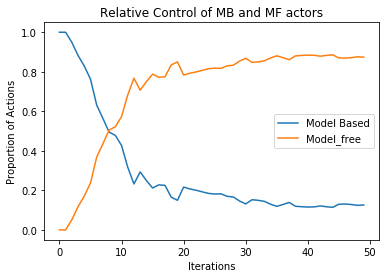

In [46]:
#print dls_count_dual
#print q_count_dual
#print total_count_dual
plt.cla()
mb_line, = plt.plot(numpy.arange(iterations), (numpy.true_divide(numpy.transpose(numpy.mean(dls_count_dual, axis=0)), numpy.transpose(numpy.mean(total_count_dual, axis=0)))), label = "GD Percentage")
mf_line, = plt.plot(numpy.arange(iterations), numpy.true_divide(numpy.transpose(numpy.mean(q_count_dual, axis=0)), numpy.transpose(numpy.mean(total_count_dual, axis=0))))
plt.legend([mb_line, mf_line], ["Model Based", "Model_free"])
plt.title("Relative Control of MB and MF actors")
plt.xlabel("Iterations")
plt.ylabel("Proportion of Actions")
plt.show()

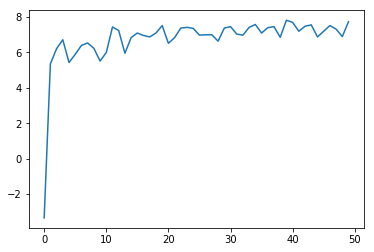

6.724


In [47]:
plt.cla()
reward_line, = plt.plot(numpy.arange(iterations), numpy.mean(reward_dual, axis=0))
plt.show()
print (numpy.mean(reward_dual))

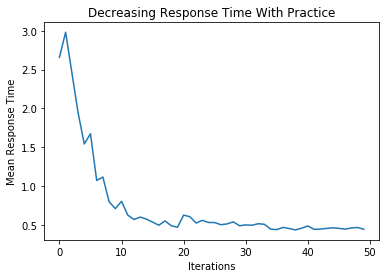

In [34]:
plt.cla()
plt.plot(numpy.arange(iterations), numpy.multiply(numpy.mean(response_time_dual, axis=0), 1000))
plt.title("Decreasing Response Time With Practice")
plt.ylabel("Mean Response Time")
plt.xlabel("Iterations")
plt.show()

Outcome devaluation for overtraining. (Change = True, change_at = 30)

In [26]:
times_dual = list()
reward_dual = list()
steps_dual = list()
time_per_reward_dual = list()
first_action_dual = list()
change = True
iterations = 50
trials = 10
change_list = [10, 20, 30, 40]
stay_percentage = numpy.zeros((trials, len(change_list)))
for i in range(trials):
    for k in range(len(change_list)):
        environment = numpy.ones((7, 7))
        environment = -0.1*environment
        trans_prob = 0.7
        environment[6, 6] = 10
        #environment[8, 8] = -10
        environment[0, 0] = -10
        mb_internal_environment = numpy.zeros((7, 7))
        #mb_internal_environment[6, 6] = 10
        start_time = time.time()
        dual_result = dual(iterations, mb_internal_environment, change, change_at=change_list[k])
        reward_dual.append(dual_result[0])
        steps_dual.append(dual_result[1])
        times_dual.append(time.time() - start_time)
        time_per_reward_dual.append(dual_result[3])
        stay_percentage[i][k] = numpy.mean(dual_result[4])
        
    #stay_percentage[i] = [numpy.mean(i) for i in first_action_dual]
    #print float(sum(first_action_dual))


In [27]:
#print collections.Counter(first_action_dual)
#print numpy.mean(numpy.sum(first_action_dual))
print (stay_percentage)

[[ 0.02564103  0.06896552  0.10526316  0.22222222]
 [ 0.07692308  0.06896552  0.21052632  0.33333333]
 [ 0.05128205  0.03448276  0.15789474  0.55555556]
 [ 0.02564103  0.06896552  0.15789474  0.22222222]
 [ 0.02564103  0.03448276  0.15789474  0.33333333]
 [ 0.1025641   0.10344828  0.21052632  0.22222222]
 [ 0.02564103  0.          0.10526316  0.33333333]
 [ 0.07692308  0.13793103  0.21052632  0.33333333]
 [ 0.07692308  0.10344828  0.10526316  0.44444444]
 [ 0.07692308  0.13793103  0.21052632  0.22222222]]


In [28]:
stay_percentage_mean = numpy.nanmean(stay_percentage, axis=0)
print (stay_percentage_mean)

[ 0.05641026  0.07586207  0.16315789  0.32222222]


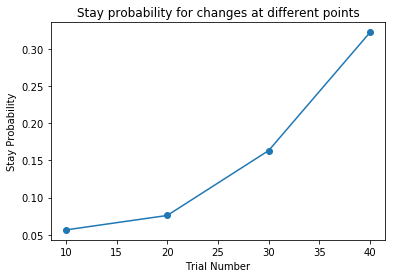

In [29]:
plt.plot([10, 20, 30, 40], stay_percentage_mean, marker = 'o')
plt.xlabel("Trial Number")
plt.ylabel("Stay Probability")
plt.title("Stay probability for changes at different points")
plt.show()

Outcome Devaluation for moderately trained. (Change == True, change_at = 10)

In [ ]:
times_dual = list()
reward_dual = list()
steps_dual = list()
time_per_reward_dual = list()
first_action_dual = list()
change_at = 10
iterations = 50
change = True
trials = 10
for i in range(trials):
    environment = numpy.zeros((7, 7))
    trans_prob = 0.7
    environment[6, 6] = 10
    #environment[8, 8] = -10
    #environment[0, 0] = -10
    mb_internal_environment = numpy.zeros((7, 7))
    #mb_internal_environment[6, 6] = 10
    start_time = time.time()
    dual_result = dual(iterations, mb_internal_environment, change, change_at)
    reward_dual.append(dual_result[0])
    steps_dual.append(dual_result[1])
    times_dual.append(time.time() - start_time)
    time_per_reward_dual.append(dual_result[3])
    first_action_dual.append(dual_result[4])

In [ ]:
#print collections.Counter(first_action_dual)
stay_percentage_moderatelytrained = list()
print collections.Counter(tuple(i) for i in first_action_dual[0][change_at:]).values()
for i in range(trials):
    stay_percentage_moderatelytrained.append((1 - max(collections.Counter(tuple(i) for i in first_action_dual[i][change_at:]).values())/float(iterations-change_at)))
print numpy.mean(stay_percentage_moderatelytrained)

In [ ]:
stay_percentage_labels = ["Overtrained", "Moderately trained"]
plt.bar(numpy.arange(2), (numpy.mean(stay_percentage_overtrain), numpy.mean(stay_percentage_moderatelytrained)), color = 'b')
plt.xticks(numpy.arange(2), stay_percentage_labels)
plt.ylabel("First Action Stay Percentage")
plt.title("Outcome Devaluation")
plt.show()

In [ ]:
times_mb = list()
reward_mb = list()
steps_mb = list()
time_per_reward_mb = list()
for i in range(10):
    environment = numpy.zeros((7, 7))
    trans_prob = 0.7
    environment[6, 6] = 10
    
    #environment[8, 8] = -10
    #environment[0, 0] = -10
    mb_internal_environment = numpy.zeros((7, 7))
    start_time = time.time()
    mb_result = mb(50, mb_internal_environment)
    reward_mb.append(mb_result[0])
    steps_mb.append(mb_result[1])
    times_mb.append(time.time() - start_time)
    time_per_reward_mb.append(mb_result[3])


In [ ]:
times_mf = list()
reward_mf = list()
steps_mf = list()
time_per_reward_mf = list()
for i in range(10):
    environment = numpy.zeros((7, 7))
    trans_prob = 0.7
    environment[6, 6] = 10
    #environment[8, 8] = -10
    #environment[0, 0] = -10
    mb_internal_environment = numpy.zeros((10, 10))
    start_time = time.time()
    mf_result = mf(50, mb_internal_environment)
    reward_mf.append(mf_result[0])
    steps_mf.append(mf_result[1])
    times_mf.append(time.time() - start_time)
    time_per_reward_mf.append(mf_result[4])

Plotting time to complete one trial -- one walk through the environment. The walk completes on reward. 
The plot shows the dual process approaches TD in completing the walk through the environment -- showing goal directed behavior converted to habits.

In [ ]:
timeperrewardmb_plot = plt.plot(numpy.arange(0, 50), numpy.mean(numpy.array(time_per_reward_mb), axis=0), color = 'b', label = 'MB')
timeperrewardmf_plot = plt.plot(numpy.arange(0, 50), numpy.mean(numpy.array(time_per_reward_mf), axis=0), color = 'r', label = 'MF')
timeperrewarddual_plot = plt.plot(numpy.arange(0, 50), numpy.mean(numpy.array(time_per_reward_dual), axis=0), color = 'g', label = 'Dual')
plt.legend()
plt.xlabel('Trial')
plt.ylabel('Time to reach goal')

#plt.xticks(numpy.arange(3), ('mb', 'dual', 'mf'))
plt.show()

In [ ]:
reward_mean_dual = numpy.mean(numpy.array(reward_dual))
reward_mean_mb = numpy.mean(numpy.array(reward_mb))
reward_mean_mf = numpy.mean(numpy.array(reward_mf))
times_mean_dual = numpy.mean(numpy.array(times_dual))
times_mean_mb = numpy.mean(numpy.array(times_mb))
times_mean_mf = numpy.mean(numpy.array(times_mf))
steps_mean_dual = numpy.mean(steps_dual)
steps_mean_mb = numpy.mean(steps_mb)
steps_mean_mf = numpy.mean(steps_mf)


In [ ]:
print steps_mean_dual

In [ ]:
stepsmf_plot, = plt.plot(numpy.arange(0, 50), numpy.mean(numpy.array(steps_mf), axis=0), color = 'r', label = 'MF')
stepsdual_plot, = plt.plot(numpy.arange(0, 50), numpy.mean(numpy.array(steps_dual), axis=0), color = 'g', label = 'Dual')
stepsmb_plot, = plt.plot(numpy.arange(0, 50), numpy.mean(numpy.array(steps_mb), axis=0), color = 'b', label = 'MB')
plt.legend()
plt.xlabel("Trials")
plt.ylabel("Steps")
plt.show()

In [ ]:
rewards = numpy.array([reward_mean_mb, reward_mean_dual, reward_mean_mf])
#yerror = numpy.array(reward_errors)
print (rewards)

In [ ]:
reward_plot, = plt.plot(numpy.arange(0, 3), rewards)
plt.xticks(numpy.arange(3), ('mb', 'dual', 'mf'))
plt.xlim(xmin = -1, xmax = 4)
#plt.ylim(ymin = 4.5, ymax = 5.5)
plt.xlabel('RL methods')
plt.ylabel("Rewards")

plt.show()

In [ ]:
times = numpy.array([times_mean_mb, times_mean_dual, times_mean_mf])
print (times)
plt.bar(numpy.arange(3), times, align='center')
plt.xticks(numpy.arange(3), ('mb', 'dual', 'mf'))
plt.xlim(xmin = -1, xmax = 4)
#plt.ylim(ymin = -1, ymax = 10)
plt.xlabel('RL methods')
plt.ylabel("Time (in secs)")

plt.show()

In [ ]:
steps = numpy.array([steps_mean_mb, steps_mean_dual, steps_mean_mf])
print (steps)
plt.bar(numpy.arange(3), steps, align='center')
plt.xticks(numpy.arange(3), ('mb', 'dual', 'mf'))
plt.xlim(xmin = -1, xmax = 3)
#plt.ylim(ymin = 350, ymax = 400)
plt.xlabel('RL methods')
plt.ylabel("Stpes")

plt.show()